In [22]:
import os
os.chdir('/Users/mikelgallo/repos2/DeepL_test')

In [23]:
# imports
#Data Manipulation
import pandas as pd
import numpy as pd

#Model fitting, performance, balancing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from Functions.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVR , SVC

In [24]:
#Defining repository path
#data_path = '/Users/mikelgallo/repos2/DeepL_test/Session 1_ Nearest Neighbors/'
data_path = './Session 1_ Nearest Neighbors/data/'

In [25]:
# Read data Train 
df = pd.read_csv(data_path+'mimic_train.csv')

# Read data Test
df_test = pd.read_csv(data_path+'mimic_test_death.csv')

In [26]:
#There is a large difference 
print(df.shape)
print(df_test.shape)

(20885, 44)
(5221, 39)


In [27]:
#Which is our dependent variable?
df['HOSPITAL_EXPIRE_FLAG'].unique()

array([0, 1])

In [28]:
# Select columns in test and add the Outcome variable to subset our train data set
df_test_cols = df_test.columns.tolist()
df_test_cols.append('HOSPITAL_EXPIRE_FLAG')

In [29]:
len(df_test_cols)

40

In [30]:
#Creating new subset
df_train= df[df_test_cols]

In [31]:
# The only column difference is our outcome variable
print(df_train.shape)
print(df_test.shape)

(20885, 40)
(5221, 39)


## Preprocessing

In [32]:
#STEP 1 - Split columns into Continuous, Discrete, Categorical
def numeric_cols(dataset):
    numeric = dataset.select_dtypes(include = np.number).columns.tolist()
    return numeric
#STEP 2 - Rough Estimate of Continuous and Discrete columns
def cont_or_disc(dataset,num):
    dict = {}
    numeric = numeric_cols(dataset)
    df_numeric = dataset[numeric]
    for i in df_numeric:
        count = df_numeric[i].count()
        unique_vals = len(df_numeric[i].unique())
        type = 'Discrete' if unique_vals < num else 'Continuous'
        dtype = df_numeric[i].dtype
        dict[i] = [count, unique_vals, type, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals', 'type', 'dtype'])
    return result
#STEP 3 - Return column names for discrete and continuous    
def numeric_col_split(df,num):
    new_df = cont_or_disc(df,num)
    cont_cols = []
    disc_cols = []
    for index,row in new_df.iterrows():
        if row['type'] == 'Discrete':
            disc_cols.append(index)
        elif row['type'] == 'Continuous':
            cont_cols.append(index)
    return disc_cols, cont_cols        

In [33]:
#Return all numeric variables 
cont_or_disc(df_train,10)

,count,unique_vals,type,dtype
subject_id,20885,16317,Continuous,int64
hadm_id,20885,19749,Continuous,int64
icustay_id,20885,20885,Continuous,int64
HeartRate_Min,18698,132,Continuous,float64
HeartRate_Max,18698,165,Continuous,float64
HeartRate_Mean,18698,14092,Continuous,float64
SysBP_Min,18677,155,Continuous,float64
SysBP_Max,18677,191,Continuous,float64
SysBP_Mean,18677,13780,Continuous,float64
DiasBP_Min,18676,96,Continuous,float64


In [34]:
disc_cols, cont_cols  = numeric_col_split(df_train,10)

In [35]:
# Conitnuous columns
print('Continuous')
print(cont_cols)
# Discrete columns
print('Dsicrete')
print(disc_cols)

Continuous
['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']
Dsicrete
['HOSPITAL_EXPIRE_FLAG']


In [36]:
## Check class balance of our outcome variable
## Train Data
df_train['HOSPITAL_EXPIRE_FLAG'].value_counts()

HOSPITAL_EXPIRE_FLAG
0    18540
1     2345
Name: count, dtype: int64

## continuous variables

In [37]:
df_train[cont_cols].describe()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,...,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000
mean,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,...,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830
std,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,...,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846
min,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,...,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440
25%,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,...,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110
50%,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,...,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460
75%,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,...,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030
max,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,...,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580


## Missing Values

In [38]:
## Getting columns with missing values
missing_cols = []
for i in df_train[cont_cols]:
    if df_train[i].isna().mean() > 0:
        missing_cols.append(i)
print(missing_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean']


In [41]:
## Simple imputation of means
#missing_cols = df.columns
#for col  in missing_cols:
    #mean = df_train[col].mean()
    #df_train[col].fillna(mean,inplace=True)
    #df_test[col].fillna(mean,inplace=True)

In [ ]:
# KNN imputation

# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

In [40]:
df_train.isna().mean()

subject_id              0.00000
hadm_id                 0.00000
icustay_id              0.00000
HeartRate_Min           0.00000
HeartRate_Max           0.00000
HeartRate_Mean          0.00000
SysBP_Min               0.00000
SysBP_Max               0.00000
SysBP_Mean              0.00000
DiasBP_Min              0.00000
DiasBP_Max              0.00000
DiasBP_Mean             0.00000
MeanBP_Min              0.00000
MeanBP_Max              0.00000
MeanBP_Mean             0.00000
RespRate_Min            0.00000
RespRate_Max            0.00000
RespRate_Mean           0.00000
TempC_Min               0.00000
TempC_Max               0.00000
TempC_Mean              0.00000
SpO2_Min                0.00000
SpO2_Max                0.00000
SpO2_Mean               0.00000
Glucose_Min             0.00000
Glucose_Max             0.00000
Glucose_Mean            0.00000
GENDER                  0.00000
DOB                     0.00000
ADMITTIME               0.00000
Diff                    0.00000
ADMISSIO

In [231]:
## How do we deal with Marital_status
##leave for later

## Creating Dummies

In [232]:
#def encode(df, columns_hot):
    #encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    #return encoded_df
#E.g. df = encode(df, ['orientation', 'neighborhood'])

In [233]:
#df_train.columns

In [234]:
#df_train = encode(df_train,['MARITAL_STATUS'])
#df_test = encode(df_test,['MARITAL_STATUS'])

## Categoricals

In [235]:
# For now we are going to get rid of categoricals - except for Maritimal 
numerics = numeric_cols(df_train)
non_numeric = [col for col in df_train.columns if col not in numerics]

In [236]:
#Remove all non-numeric from datasets
df_train = df_train.drop(non_numeric,axis = 1)
df_test = df_test.drop(non_numeric,axis = 1)
#df = df.drop(['column'],axis=1)

In [237]:
df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff'],
      dtype='object')

## Spliting Data

In [238]:
from sklearn.model_selection import train_test_split
# In case we use directly a Train and Test datatset
Xtrain = df_train.drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
ytrain = df_train['HOSPITAL_EXPIRE_FLAG']
Xtest_id = df_test[['icustay_id']]
Xtest = df_test.drop(['subject_id','hadm_id','icustay_id'],axis = 1) #probably it doesnt require to remove any column

In [283]:
sampling_strategy = 0.5
ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X_res, y_res = ros.fit_resample(Xtrain, ytrain)

## Scaling Data

In [239]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [240]:
Xtrain_s

array([[ 1.37135345,  2.00846328,  2.47441583, ...,  0.51976324,
         0.49085993, -0.96804972],
       [-0.47663105,  0.24045868, -0.41829474, ..., -0.85916691,
        -0.80289232,  0.7926984 ],
       [ 0.80274283, -0.36571433,  0.44912231, ...,  1.77925849,
         1.76402976,  0.89902512],
       ...,
       [-0.83201269, -0.41622875, -0.56900343, ...,  3.01703831,
         1.14520001,  1.10301394],
       [-0.76093636, -0.16365666, -0.23015689, ..., -0.98945952,
        -1.07159471, -0.71009725],
       [-0.76093636, -0.41622875, -0.52809007, ...,  0.4329015 ,
         0.99405492, -1.25936233]])

In [241]:
print(Xtrain.shape)
print(Xtest.shape)

(20885, 25)
(5221, 25)


## Running a KNN

In [242]:
# Step 1 - Create an instance of the KNN model
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(n_neighbors=20, algorithm = 'brute')
KNN_model.fit(Xtrain,ytrain)

print(f"Predicted class is ",KNN_model.predict(Xtest))
## Check which other algorithm should we try

Predicted class is  [0 0 0 ... 0 0 0]


In [243]:
y_predict = KNN_model.predict(Xtest)

In [244]:
y_predict_proba = KNN_model.predict_proba(Xtest)

In [245]:
y_predict[30:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [256]:
y_proba = pd.DataFrame(y_predict_proba[:,1])

In [267]:
# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_proba[0]})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)

## KNN Hypertuning

In [276]:
# Step 1 - Create an instance of the KNN model
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(algorithm = 'brute')

# Step 2 - Create our grid_search_values
grid_values = {'n_neighbors': [5, 15, 25, 30, 35, 50], 'weights': ['uniform','distance']}

# Step 3 - Instanciate our gridSearch CV
grid_knn_acc = GridSearchCV(KNN_model, param_grid = grid_values, scoring='roc_auc',cv=10)

#Step 4 - fit model 
grid_knn_acc.fit(Xtrain,ytrain)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(algorithm='brute'),
             param_grid={'n_neighbors': [5, 15, 25, 30, 35, 50],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

best parameters: {'n_neighbors': 15, 'weights': 'distance'}
best score:      0.59471 (+/-0.01859)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
3,15,distance,"{'n_neighbors': 15, 'weights': 'distance'}",0.608240,0.550453,0.598852,0.602968,0.597031,0.601032,0.622445,0.598408,0.574744,0.592956,0.594713,0.018593,1
5,25,distance,"{'n_neighbors': 25, 'weights': 'distance'}",0.604547,0.566857,0.592497,0.599329,0.602584,0.607476,0.610798,0.600218,0.560832,0.585625,0.593076,0.016176,2
9,35,distance,"{'n_neighbors': 35, 'weights': 'distance'}",0.592419,0.569570,0.594462,0.606842,0.591627,0.607376,0.606093,0.609475,0.551194,0.595092,0.592415,0.017729,3
7,30,distance,"{'n_neighbors': 30, 'weights': 'distance'}",0.603561,0.559914,0.591487,0.598890,0.594354,0.606952,0.601501,0.607008,0.556090,0.594457,0.591422,0.017458,4
11,50,distance,"{'n_neighbors': 50, 'weights': 'distance'}",0.598086,0.583631,0.579460,0.608979,0.592977,0.590044,0.614430,0.609984,0.539794,0.592134,0.590952,0.020245,5
2,15,uniform,"{'n_neighbors': 15, 'weights': 'uniform'}",0.594536,0.541482,0.595024,0.595490,0.590417,0.589415,0.614948,0.585569,0.561095,0.586428,0.585440,0.019269,6
8,35,uniform,"{'n_neighbors': 35, 'weights': 'uniform'}",0.576689,0.563990,0.584564,0.596531,0.584948,0.597497,0.590863,0.593648,0.539276,0.587919,0.581592,0.017006,7
4,25,uniform,"{'n_neighbors': 25, 'weights': 'uniform'}",0.590667,0.559425,0.583054,0.588822,0.594730,0.597934,0.595716,0.584065,0.545700,0.575034,0.581515,0.016139,8
6,30,uniform,"{'n_neighbors': 30, 'weights': 'uniform'}",0.591259,0.551530,0.581216,0.587567,0.583971,0.596013,0.583942,0.591159,0.540933,0.586581,0.579417,0.017247,9
10,50,uniform,"{'n_neighbors': 50, 'weights': 'uniform'}",0.583820,0.578392,0.565825,0.596763,0.585134,0.578889,0.599249,0.593279,0.526872,0.579955,0.578818,0.019703,10


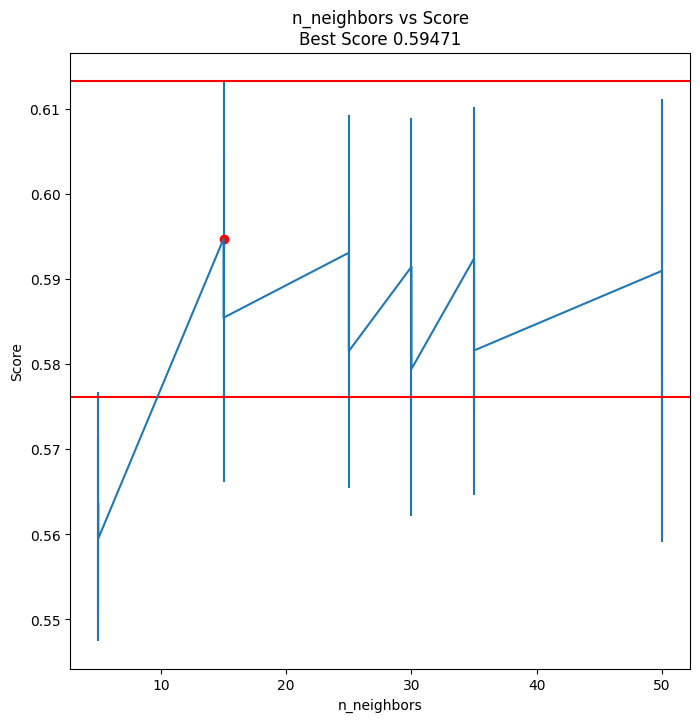

In [277]:
# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [278]:
#Best Result
print('best parameters:', grid_knn_acc.best_params_)
print('best score:', grid_knn_acc.best_score_)

best parameters: {'n_neighbors': 15, 'weights': 'distance'}
best score: 0.5947129128901145


In [280]:
y_predict_grids_proba = grid_knn_acc.predict_proba(Xtest)[:,1]

In [281]:
y_predict_grids_proba

array([0.        , 0.138097  , 0.        , ..., 0.06815731, 0.05364054,
       0.0738678 ])

In [282]:
# Produce .csv for kaggle testing
test_predictions_submit_knn_grid = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_predict_grids_proba[0]})
test_predictions_submit_knn_grid.to_csv("test_predictions_submit_kgrid.csv", index = False)

## Running a SVM

In [272]:
# Create a Support Vector Machine classifier with a linear kernel
classifier = SVC(kernel='rbf', probability=True)

# Train the classifier on the training set
classifier.fit(Xtrain, ytrain)

# Obtain decision values or probabilities on the training set
#y_train_scores = classifier.decision_function(X_train_scaled)  # Use decision_function for linear kernel
# Alternatively, you can use predict_proba for non-linear kernels
y_train_probs = classifier.predict_proba(Xtest)[:, 1]

# Calculate AUC score on the training set
#auc_score_train = roc_auc_score(y_train, y_train_scores)

# Print or use the AUC score as needed
#print("AUC score on the training set:", auc_score_train)

In [274]:
len(y_train_probs)

5221

In [275]:
# Produce .csv for kaggle testing
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs[0]})
test_predictions_submit_SVM.to_csv("test_predictions_submit_svm.csv", index = False)